In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('../..')
import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes
from data_functions import make_date_to_MYR

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time



from diabetes_onset_plotter import survival_fit_res, make_results

In [3]:
%%time
p = '../tempNN/'
treated = pd.read_pickle(p+'treated0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls = pd.read_pickle(p+'match0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

pmpm = pd.read_pickle(p+'pmpm.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

#treated['Treatment'] = 1
#controls['Treatment'] = 0

CPU times: user 10.3 s, sys: 11 s, total: 21.3 s
Wall time: 21.3 s


In [4]:
def datecols(dat):
    """
    Make MYR to date
    
    """
    dat['YEAR'] = (dat.MYR//100).astype(int)
    dat['MONTH'] = (dat.MYR%100).astype(int)
    dat['DAY'] = 1
    dat['DATE'] = pd.to_datetime(dat[['YEAR', 'MONTH', 'DAY']])
    return dat

def timestats(dat):
    """
    Length: Number of data points per ID
    Months: Number of Months between Last Month and First Month (this should the same as Length for good data)
    Mean Gap: When data are not consecutive what is the average Gap between months
    Max Gap: the maximum Gap in an Patient
    DIFF: Difference between month span and month points
    
    """
    dat['DELTA'] = (dat.groupby('PERS_ID')['DATE'].diff()/np.timedelta64(1, 'M')).round()
    dat.dropna(inplace = True)
    dat.reset_index(drop = True, inplace = True)
    time_stats= dat.groupby('PERS_ID').apply(lambda x: pd.Series([len(x), ((x.DATE.iloc[-1]-x.DATE.iloc[0])/np.timedelta64(1, 'M'))+1,
                                                                  (x.DELTA-1).mean(), (x.DELTA-1).max()],
                                                    index = ['Length', 'Months','Mean Gap', 'Max Gap'])).reset_index()
    
    time_stats.Months = time_stats.Months.round()
    time_stats['DIFF'] = np.abs(time_stats.Length.values-time_stats.Months.values)
    return time_stats

def aggregate_time_stats(dat):
    """
    Mean DIFF: Mean difference of the differences between time points and months
    Mean Mean Gap: the mean of the mean of the Gaps across all patients
    #Patients with Non Zero Gap: as the name suggests
    'Mean Gap Fof Patients with Non Zero Gap'
    
    """
    dat['Mean DIFF'] = dat.DIFF.mean()
    dat['Mean Mean Gap'] = dat['Mean Gap'].mean()
    dat['#Patients with Non Zero Gap'] = len(dat[dat['Max Gap'] >0])
    dat['Mean Gap For Patients with Non Zero Gap'] = dat[dat['Max Gap']>0]['Mean Gap'].mean()
    return dat


def combine_above_three(dat):
    dat = datecols(dat.copy())
    dat = timestats(dat.copy())
    dat = aggregate_time_stats(dat.copy())
    return dat

In [5]:
tdates = datecols(treated[['PERS_ID', 'MYR']])
cdates = datecols(controls[['PERS_ID', 'MYR']])

In [6]:
%%time
tstats, cstats = timestats(tdates.copy()), timestats(cdates.copy())

CPU times: user 10.9 s, sys: 237 ms, total: 11.2 s
Wall time: 11 s


In [7]:
tstats2, cstats2 = aggregate_time_stats(tstats.copy()), aggregate_time_stats(cstats.copy())


In [8]:
cstats2.tail(3)

PERS_ID  Length  Months  Mean Gap  Max Gap  DIFF  Mean DIFF  \
7097  5062496     3.0     3.0       0.0      0.0   0.0   0.557887   
7098  5063066     3.0     3.0       0.0      0.0   0.0   0.557887   
7099  5064471     2.0     2.0       0.0      0.0   0.0   0.557887   

      Mean Mean Gap  #Patients with Non Zero Gap  \
7097       0.068671                         1073   
7098       0.068671                         1073   
7099       0.068671                         1073   

      Mean Gap For Patients with Non Zero Gap  
7097                                 0.454395  
7098                                 0.454395  
7099                                 0.454395

In [9]:
tstats2.tail(3)

PERS_ID  Length  Months  Mean Gap  Max Gap  DIFF  Mean DIFF  \
1519  5042108     7.0     7.0       0.0      0.0   0.0   0.245729   
1520  5048711     3.0     3.0       0.0      0.0   0.0   0.245729   
1521  5051718     3.0     3.0       0.0      0.0   0.0   0.245729   

      Mean Mean Gap  #Patients with Non Zero Gap  \
1519       0.029717                          137   
1520       0.029717                          137   
1521       0.029717                          137   

      Mean Gap For Patients with Non Zero Gap  
1519                                 0.330145  
1520                                 0.330145  
1521                                 0.330145

In [10]:
def findDate(dat, dat2,  past_months):
    
    first = dat[['PERS_ID', 'MYR']].groupby('PERS_ID').apply(lambda x : x.iloc[0]).reset_index(drop = True)
    first['year'] = (first.MYR//100).astype(int)
    first['month'] = (first.MYR%100).astype(int)
    first['day'] = 1
    first['REG_DATE'] = pd.to_datetime(first[['year','month','day']])
    first['PAST_DATE'] = (first.REG_DATE - pd.DateOffset(months = past_months)).apply(make_date_to_MYR)
    first['REG_DATE'] = first['REG_DATE'].apply(make_date_to_MYR)
    first = first[['PERS_ID',  'REG_DATE', 'PAST_DATE']]
    dat2['PERS_ID'] = dat2.PERS_ID.astype(int)
    first['PERS_ID'] = first.PERS_ID.astype(int)

    dat3 =  dat2.merge(first, how = 'right', on = 'PERS_ID')
    dat3['IN_STUDY'] = 0
   # dat2['PERS_ID'] = dat2.PERS_ID.astype(int)
   # dat['PERS_ID'] = dat.PERS_ID.astype(int)

   # dat_all_months = dat2.merge(dat['PERS_ID','REG', how = 'right', on = 'PERS_ID')
    return dat3
    

In [11]:
treated2 = findDate(treated.copy(), pmpm.copy(), 6)
controls2 = findDate(controls.copy(), pmpm.copy(), 6)

In [12]:
def firstdate(group):
    date = group['PAST_DATE'].iloc[0]
    if date in group.MYR.unique():
        group = group[group.MYR >= date]
        group['IN_STUDY'] = 1
    return group

def filter_first_date(data):
    data = data.groupby('PERS_ID').apply(firstdate)
    filt = data['IN_STUDY'] == 1
    data = data[filt].reset_index(drop = True)
    return data

In [13]:
%%time
treated2 = (filter_first_date(treated2)).sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls2 = (filter_first_date(controls2)).sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

controls2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
treated2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
treated2['Treatment'] = 1
controls2['Treatment'] = 0


CPU times: user 20.1 s, sys: 432 ms, total: 20.6 s
Wall time: 20.5 s


In [14]:
treated2.PERS_ID.unique().shape, controls2.PERS_ID.unique().shape

In [15]:
treated2.PERS_ID.unique().shape, treated.PERS_ID.unique().shape

In [16]:
#treated2 = treated2[treated2.REG_DATE <= treated2.MYR].sort_values(by =['PERS_ID', 'MYR']).reset_index(drop = True)
#controls2 = controls2[controls2.REG_DATE <= controls2.MYR].sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

In [17]:
treated2.PERS_ID.unique().shape, controls2.PERS_ID.unique().shape

In [18]:
%%time
tstats6 = combine_above_three(treated2.copy())
cstats6 = combine_above_three(controls2.copy())

CPU times: user 9.7 s, sys: 236 ms, total: 9.94 s
Wall time: 9.83 s


In [19]:
cstats6.tail(3)

PERS_ID  Length  Months  Mean Gap  Max Gap  DIFF  Mean DIFF  \
6155  5038355    10.0    10.0       0.0      0.0   0.0    0.63381   
6156  5039929     6.0     6.0       0.0      0.0   0.0    0.63381   
6157  5040413     9.0     9.0       0.0      0.0   0.0    0.63381   

      Mean Mean Gap  #Patients with Non Zero Gap  \
6155       0.042831                         1080   
6156       0.042831                         1080   
6157       0.042831                         1080   

      Mean Gap For Patients with Non Zero Gap  
6155                                 0.244217  
6156                                 0.244217  
6157                                 0.244217

In [20]:
tstats6.tail(3)

PERS_ID  Length  Months  Mean Gap  Max Gap  DIFF  Mean DIFF  \
1354  5030695     9.0     9.0       0.0      0.0   0.0   0.250553   
1355  5032283    10.0    10.0       0.0      0.0   0.0   0.250553   
1356  5040700    10.0    10.0       0.0      0.0   0.0   0.250553   

      Mean Mean Gap  #Patients with Non Zero Gap  \
1354         0.0169                          141   
1355         0.0169                          141   
1356         0.0169                          141   

      Mean Gap For Patients with Non Zero Gap  
1354                                 0.162651  
1355                                 0.162651  
1356                                 0.162651

In [21]:
data = [treated,  controls]

for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [22]:
data2 = [treated2,  controls2]

for d in data2:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [23]:
treated2.shape, treated.shape

In [24]:
#ids = treated2.PERS_ID.unique()
#trtr = treated[treated.PERS_ID.astype(int).isin(ids)].reset_index(drop = True)

In [35]:
treated2

PERS_ID     MYR  MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT MEDICAID_LOB  \
0      2602482  201902         0               81        243   Commercial   
1      2602482  201903         0               81        310   Commercial   
2      2602482  201904         0               81        244   Commercial   
3      2602482  201905         0               81        405   Commercial   
4      2602482  201906         0               81          0   Commercial   
...        ...     ...       ...              ...        ...          ...   
26856  5040700  202012         0               31        270   Commercial   
26857  5040700  202101         0               31        179   Commercial   
26858  5040700  202102         0               31          0   Commercial   
26859  5040700  202103         0               31        188   Commercial   
26860  5040700  202104         0               31        120   Commercial   

       ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  ...  ER_BIN  IP_C  ER_C  \
0           0.0       0.0      0.0           0.0  ...       0     0     0   
1           0.0       0.0      0.0           0.0  ...       0     0     0   
2           0.0       0.0      0.0           0.0  ...       0     0     0   
3           0.0       0.0      0.0           0.0  ...       0     0     0   
4           0.0       0.0      0.0           0.0  ...       0     0     0   
...         ...       ...      ...           ...  ...     ...   ...   ...   
26856       0.0       0.0      0.0           0.0  ...       0     0     0   
26857       0.0       0.0      0.0           0.0  ...       0     0     0   
26858       0.0       0.0      0.0           0.0  ...       0     0     0   
26859       0.0       0.0      0.0           0.0  ...       0     0     0   
26860       0.0       0.0      0.0           0.0  ...       0     0     0   

       IP_BIN6  ER_BIN6  REG_DATE  PAST_DATE  IN_STUDY  Treatment  Acute-bin  
0          0.0      0.0    201908     201902         1          1          0  
1          0.0      0.0    201908     201902         1          1          0  
2          0.0      0.0    201908     201902         1          1          0  
3          0.0      0.0    201908     201902         1          1          0  
4          0.0      0.0    201908     201902         1          1          0  
...        ...      ...       ...        ...       ...        ...        ...  
26856      0.0      0.0    202012     202006         1          1          0  
26857      0.0      0.0    202012     202006         1          1          0  
26858      0.0      0.0    202012     202006         1          1          0  
26859      0.0      0.0    202012     202006         1          1          0  
26860      0.0      0.0    202012     202006         1          1          0  

[26861 rows x 90 columns]

In [26]:
#(treated2['Acute-bin'] == trtr['Acute-bin']).all()

In [27]:
#trtr

PERS_ID     MYR  MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT MEDICAID_LOB  \
0      2602482  201908         0               81          0   Commercial   
1      2602482  201909         0               81       1379   Commercial   
2      2602482  201910         0               81        739   Commercial   
3      2602482  201911         0               82          0   Commercial   
4      2602482  201912         0               82        518   Commercial   
...        ...     ...       ...              ...        ...          ...   
18794  5040700  202012         0               31        270   Commercial   
18795  5040700  202101         0               31        179   Commercial   
18796  5040700  202102         0               31          0   Commercial   
18797  5040700  202103         0               31        188   Commercial   
18798  5040700  202104         0               31        120   Commercial   

       ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  ...  CC_VISUAL_IMPAIR  LOB  \
0           0.0       0.0      0.0           0.0  ...               0.0    1   
1           0.0       0.0      0.0           0.0  ...               0.0    1   
2           0.0       0.0      0.0           0.0  ...               0.0    1   
3           0.0       0.0      0.0           0.0  ...               0.0    1   
4           0.0       0.0      0.0           0.0  ...               0.0    1   
...         ...       ...      ...           ...  ...               ...  ...   
18794       0.0       0.0      0.0           0.0  ...               0.0    1   
18795       0.0       0.0      0.0           0.0  ...               0.0    1   
18796       0.0       0.0      0.0           0.0  ...               0.0    1   
18797       0.0       0.0      0.0           0.0  ...               0.0    1   
18798       0.0       0.0      0.0           0.0  ...               0.0    1   

       PREGNANCY  IP_BIN  ER_BIN  IP_C  ER_C  IP_BIN6  ER_BIN6  Acute-bin  
0            0.0       0       0     0     0      0.0      0.0          0  
1            0.0       0       0     0     0      0.0      0.0          0  
2            0.0       0       0     0     0      0.0      0.0          0  
3            0.0       0       0     0     0      0.0      0.0          0  
4            0.0       0       0     0     0      0.0      0.0          0  
...          ...     ...     ...   ...   ...      ...      ...        ...  
18794        0.0       0       0     0     0      0.0      0.0          0  
18795        0.0       0       0     0     0      0.0      0.0          0  
18796        0.0       0       0     0     0      0.0      0.0          0  
18797        0.0       0       0     0     0      0.0      0.0          0  
18798        0.0       0       0     0     0      0.0      0.0          0  

[18799 rows x 86 columns]

In [28]:
times = [0, 6, 12]
onset = 'Acute-bin'

curves = []
for time in times:
    survTr = treated2.copy().groupby('PERS_ID').apply(survival_diabetes,  grace = time, onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
    survCo = controls2.copy().groupby('PERS_ID').apply(survival_diabetes, grace = time, onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
    curves.append((survTr, survCo))
    
    

In [29]:
filter_cols =  ['AGE_AT_MIDMONTH',  'ALLOW_AMT','CC_TOBACCO',  'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'T', 'E']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']
#normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

model_type = 'kaplan'
model = KaplanMeierFitter
model_argsK = {}#{'timeline':24}# {"penalizer":0.001, 'alpha': 0.05}
model_args= {}
fit_args = {"step_size": 0.1, "show_progress":False}

timeline = 24
fit_args1 = {"timeline":np.arange(timeline)}
#put title in the figures 1 0 no
outcome_title = 1

kaplan_plot_params = {"show_censors": False, "ci_alpha":0.1, "ci_force_lines":False}# "at_risk_counts": False}

In [30]:
path_tabs = './res/tabs/'
path_figs = './res/figs/'
path_figs2 = './res/figs2' #plots without risk at count

#create paths if not created
from pathlib import Path
p1 = Path(path_tabs)
p2 = Path(path_figs)
p3 = Path(path_figs2)

p1.mkdir(parents = True, exist_ok = True)
p2.mkdir(parents = True, exist_ok = True)
p3.mkdir(parents = True, exist_ok = True)

In [31]:
filter_cols2 =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'T', 'E', 'Treatment']

summary_names =  ['Age','Gender', 'Total Cost',  'Tobacco use',  'Obesity', 
            'Hypertension', 'Hypothyroid', 'Disease Count',  'Treatment']

In [32]:
#from lifelines import KaplanMeierFitter


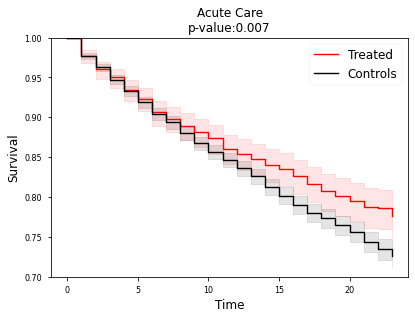

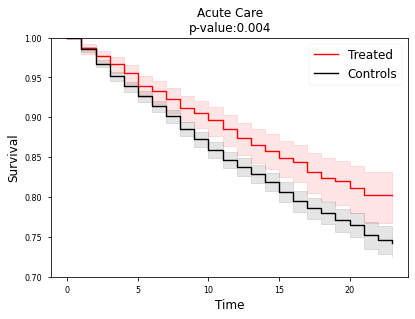

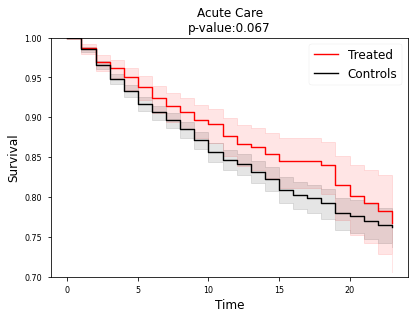

In [33]:
rmsts = []
for (tr, cr) in curves:
    fitted, rmst = survival_fit_res( ['Treated', 'Controls'],  tr, cr,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)
    
    rmsts.append(rmst)
    outcome = 'Acute Care'
    logrank_summ = logrank_test(tr['T'], cr['T'], event_observed_A=tr['E'], event_observed_B=cr['E'] ).summary
    fig, ax = plt.subplots()
    for name, mod in fitted.items():
        
        #plot data on the axes
        ax = mod.plot(**kaplan_plot_params, ax = ax)
        
    
    #customize plots
    ax.collections[0].set_color('r')
    ax.collections[1].set_color('k')
    ax.set_xlabel('Time', fontsize =12)
    ax.set_ylabel('Survival', fontsize = 12)
    ax.lines[0].set_color('r')
    ax.lines[1].set_color('k')
    ax.legend(list(fitted.keys()), fontsize = 12)
    ax.set_ylim([0.7,1])
    if outcome_title:
        ax.set_title(outcome+'\np-value:'+'{:.3f}'.format(logrank_summ['p'].iloc[0]), fontsize = 12)


    

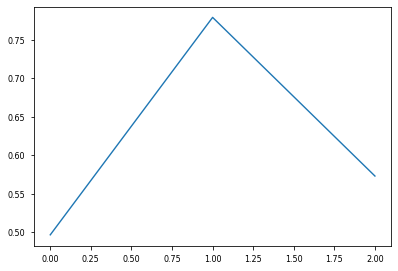

In [34]:
fig, ax = plt.subplots()
ax.plot(rmsts)
plt.show()